In [1]:
# Download dataset.
!pip install -U tensorflow_datasets

# Import Tensorflow.
import tensorflow as tf
import tensorflow_datasets as tfds
tf.logging.set_verbosity(tf.logging.ERROR)

# Import helper libraries.
import math
import numpy as np
import matplotlib.pyplot as plt

# Import display libraries.
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.3.2)


In [2]:
# Print info.
print("TensorFlow Version:", tf.__version__)

tf.enable_eager_execution()

TensorFlow Version: 1.15.0


In [3]:
# Loading the dataset.
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/1.0.0. Subsequent calls will reuse this data.


In [4]:
# Explore the data.
class_names = [
               'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankel boot'
              ]

num_train_samples = metadata.splits['train'].num_examples
num_test_samples = metadata.splits['test'].num_examples
print("NumOfLabels:         ", len(class_names))
print("NumOfSamples (Train):", num_train_samples)
print("NUmOfSamples (Test): ", num_test_samples)

NumOfLabels:          10
NumOfSamples (Train): 60000
NUmOfSamples (Test):  10000


In [0]:
# Process and normalise the data.
def normalise(images, labels):
  # Casting to float.
  images = tf.cast(images, tf.float32)

  # Normalise into [0, 1]
  images /= 255.0
  return images, labels

# Process the data.
train_dataset = train_dataset.map(normalise)
test_dataset = test_dataset.map(normalise)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

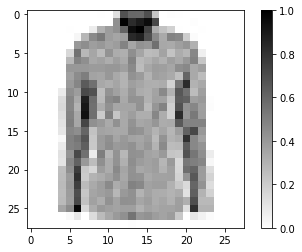

In [6]:
# Explore the data.
for image, label in test_dataset.take(1):
  break;
image = image.numpy().reshape((28, 28))

# Plot the image.
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

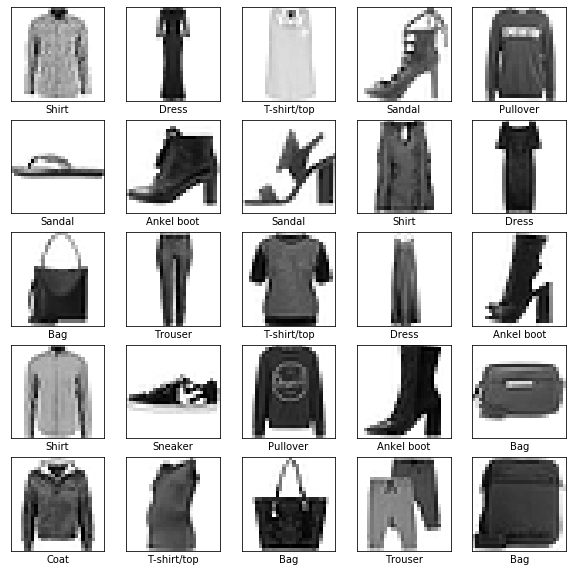

In [8]:
# Explore more.
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
  image = image.numpy().reshape((28, 28))
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i += 1
plt.show()

In [0]:
# Build the model.
'''
# Previous sample.
# Flatten the data.
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
                             tf.keras.layers.Dense(128, activation=tf.nn.relu),
                             tf.keras.layers.Dense(10, activation=tf.nn.softmax)
                           ])
'''
# ** New Step **
# Build a convolution layer, before flatten the data.
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
                             tf.keras.layers.MaxPool2D((2, 2), strides=2),
                             tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
                             tf.keras.layers.MaxPool2D((2, 2), strides=2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation=tf.nn.relu),
                             tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])


# Compile the model.
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Train the model.
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_samples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Train with 10 ephocs instead of 5 from the previous sample.
model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_samples/BATCH_SIZE))

Train for 1875 steps
Epoch 1/10
1875/1875 [==============================] - 21s 11ms/step - loss: 0.4022 - acc: 0.8543
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2625 - acc: 0.9042
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2161 - acc: 0.9200
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1819 - acc: 0.9315
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1613 - acc: 0.9415
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1351 - acc: 0.9497
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1179 - acc: 0.9567
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0962 - acc: 0.9635
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0824 - acc: 0.9689
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0698 - acc: 0.9744


In [11]:
# Evaluate the accuracy.
# NB! We will see that the accuracy would drop from 0.9744 to 0.9151.
# This could be due to overtraining.
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_samples/BATCH_SIZE))
print("Accuracy on test dataset:", test_accuracy)

313/313 [==============================] - 2s 8ms/step - loss: 0.3107 - acc: 0.9151
Accuracy on test dataset: 0.9151


In [12]:
# Predict using the model.
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

print("Shape: ", predictions.shape)
print("Predict (0)", predictions[0])
print("Index:", np.argmax(predictions[0]))
print("Label Index:", test_labels[0])
print("Predict Answer:", class_names[test_labels[0]])

Shape:  (32, 10)
Predict (0) [2.1890460e-07 4.6483320e-10 5.0580100e-05 2.8673808e-08 9.5389737e-03
 5.7972471e-10 9.9040961e-01 3.8710987e-10 1.8100319e-12 5.1189699e-07]
Index: 6
Label Index: 6
Predict Answer: Shirt


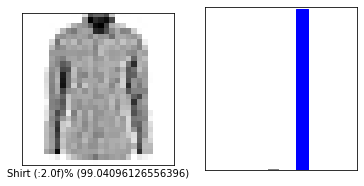

In [13]:
# Explore the training.
def plot_image(i, predictions_array, true_labels, images):
  prediction_array = predictions_array[i]
  true_label = true_labels[i]
  img = images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(prediction_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} (:2.0f)% ({})".format(
      class_names[predicted_label],
      100 * np.max(prediction_array),
      class_names[true_label],
      color=color
      ))
  
def plot_value_array(i, predictions_array, true_labels):
  prediction_array, true_label = predictions_array[i], true_labels[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), prediction_array, color='grey')
  plt.ylim(0, 1)
  predicted_label = np.argmax(prediction_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def plot_data(i):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(1,2,2)
  plot_value_array(i, predictions, test_labels)

plot_data(0)

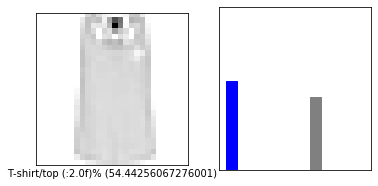

In [14]:
plot_data(2)

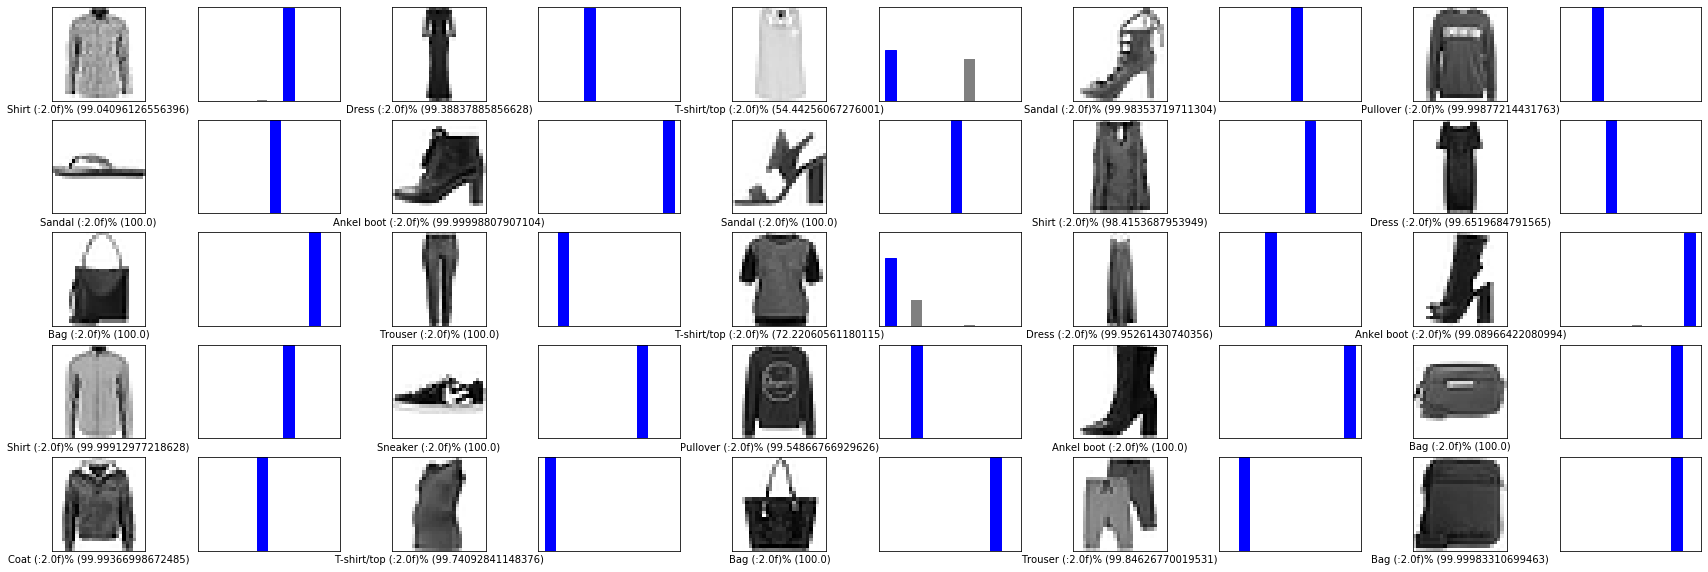

In [15]:
# Print 15 data.
num_rows = 5
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 3 * num_cols, 2 * num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
  plot_value_array(i, predictions, test_labels)

(28, 28, 1)
(1, 28, 28, 1)
Layer Data: [[2.1890503e-07 4.6483320e-10 5.0580242e-05 2.8673862e-08 9.5389923e-03
  5.7972693e-10 9.9040961e-01 3.8711209e-10 1.8100354e-12 5.1189892e-07]]
Index:  6


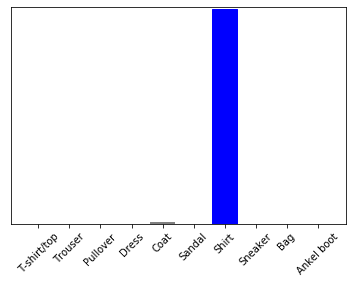

In [16]:
# Grab an image from the test dataset.
img = test_images[0]
print(img.shape)

# Add the image to a batch where it's the only member.
img = np.array([img])
print(img.shape)

# Predict the image.
predict_image = model.predict(img)
print("Layer Data:", predict_image)
print("Index: ", np.argmax(predict_image[0]))

plot_value_array(0, predict_image, test_labels)
disp = plt.xticks(range(10), class_names, rotation=45)